# Simple Example Illustrating Haar Fluctuation Analysis under Different UNTB Parameter Choices

In [ ]:
src_path = "../Blind_Review_Code_Repository_2025/src/"


In [88]:
# Library Imports
import os
os.chdir(src_path)

# From src
## UNTB Functions
import untbPython
## Diversity Metric Functions
import analysisFunctions 
import divDynFunctions
import samplingFunctions
import diversityMetrics
## Haar Fluctuation Analysis Functions
import haarFluctuationAnalysis
import crossHaarCorrelation

# Other Imports
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import set_num_threads # Set number of threads for computations
import matplotlib
from scipy.stats import pearsonr

In [89]:
# Leading eigenvalue -- death rate * (speciation rate / population size)
# https://www.sciencedirect.com/science/article/pii/S0025556408000047?casa_token=uJsOivxpXqYAAAAA:qKWLH0ko0rIRh_BE-E4lwA9ad8jgqxj0q4KTACKdnSaofKQyJKl4-MqXtyMCa7SuVzCviEgQ
def firstEigen(u, m, x):
    # u = death rate, m = mutation, x = community size
    return (u * (m / x)) 

In [90]:
# Welford's online algorithm
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
# Also here: https://nbviewer.org/github/changyaochen/changyaochen.github.io/blob/master/assets/notebooks/welford.ipynb#correctness
def welford_mean_var(i_step, untb_richness, num_simulations, richness_mean, richness_variance):
    # Update mean and variance incrementally
    if richness_mean is None:
        richness_mean = untb_richness
        richness_variance = np.zeros_like(untb_richness)
    else:
        # Update the mean (incrementally)
        new_mean = richness_mean + (untb_richness - richness_mean) / (i_step + 1)
        # Update the variance (incrementally)
        richness_variance += (untb_richness - richness_mean) * (untb_richness - new_mean)
        # Update the mean for the next iteration
        richness_mean = new_mean
    return richness_mean, richness_variance

In [ ]:
# Number of simulations to run
num_simulations = 25
J = 1000
model_steps = 10000
expanded_community = np.repeat(1,J)

# Variables to store mean and variance (for std)
richness_mean_results = {}  
richness_variance_results = {} 

# Parameters
params = np.array(([0.2, 5],[0.1, 25], [0.05, 100]))

# Perform simulations
for k in range(params.shape[0]):
    richness_mean = None
    richness_variance = None

    richness_mean_results[k] = []
    richness_variance_results[k] = []

    for i in range(num_simulations):
        # Parameters 1
        untb_results, ancs, desc, _ = untbPython.untb_Hankin_Phylo_V2(expanded_community, mutation_probability= params[k,0], death_rate= int(params[k,1]), generations=model_steps, keep=False)
        untb_richness = untbPython.return_richness(untb_results)
        richness_mean, richness_variance = welford_mean_var(i, untb_richness, num_simulations, richness_mean, richness_variance)

    richness_mean_results[k] = richness_mean
    richness_variance_results[k] = richness_variance

In [ ]:
# Number of simulations to run
# Have farily large number of simulations to recreate publication figure
expanded_community = np.repeat(1,J)

# Variables to store mean and variance (for std)
haar_mean_results = {}  
haar_variance_results = {} 
haar_time_axis = {} 

# Parameters
cutoffs = np.array([5000, 5000, 5000]) # From above

# Perform simulations
for k in range(params.shape[0]):
    haar_mean = None
    haar_variance = None
    time_axis = None

    haar_mean_results[k] = []
    haar_variance_results[k] = []
    haar_time_axis[k] = []

    for i in range(num_simulations):
        # Parameters 1
        untb_results, ancs, desc, _ = untbPython.untb_Hankin_Phylo_V2(expanded_community, mutation_probability= params[k,0], death_rate= int(params[k,1]), generations=model_steps, keep=False)
        untb_richness = untbPython.return_richness(untb_results)

        haar_pop, _, _ = haarFluctuationAnalysis.Haar_hebert(np.array(untb_richness.T[1,cutoffs[k]:]), np.array(untb_richness.T[0,cutoffs[k]:]), Scales = None, q = 1, overlap = 0, returnFull = False, allq = False)
        time_axis = haar_pop[:,0]

        haar_mean, haar_variance = welford_mean_var(i, haar_pop[:,1], num_simulations, haar_mean, haar_variance)

    haar_mean_results[k] = haar_mean
    haar_variance_results[k] = haar_variance
    haar_time_axis[k] = time_axis

/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_6473/2761171747.py:47: RuntimeWarning: invalid value encountered in log10
  axs[1].fill_between(np.log10(x), np.log10(y - std), np.log10(y + std), color=fill_colour[k], alpha=0.3)
/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_6473/2761171747.py:67: RuntimeWarning: divide by zero encountered in log10
  return np.log10(x)


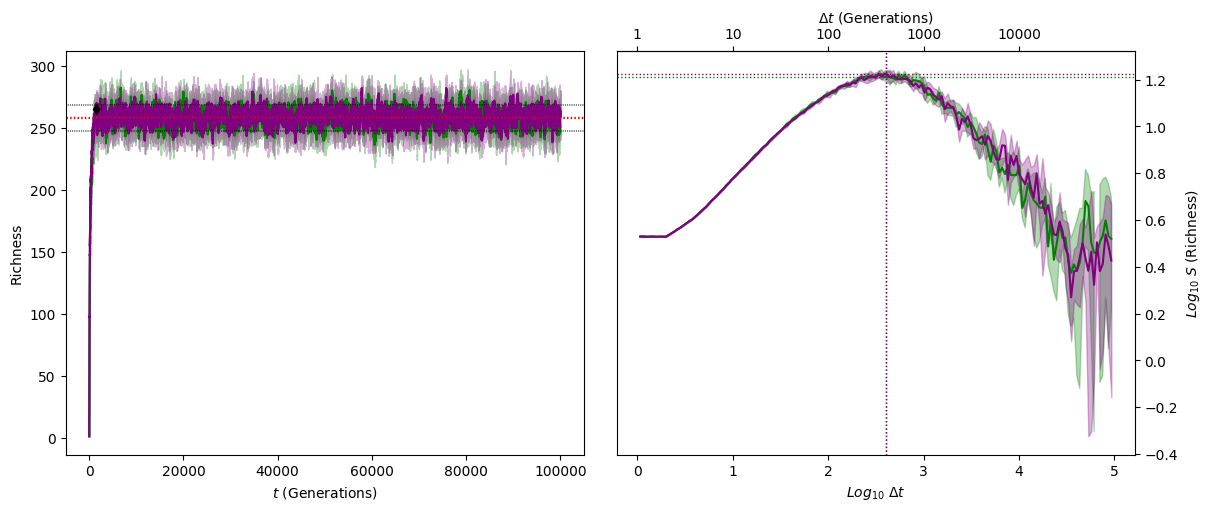

In [96]:
# Plot of Simulation Runs
colours = ["green", "purple", "blue"]
fill_colour = ["green", "purple", "blue"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True, gridspec_kw={'wspace': 0.05})

# Panel A

for k in range(params.shape[0]):
    var = richness_variance_results[k][:,1].copy()
    var /= num_simulations
    std = np.sqrt(var)

    x_a = richness_mean_results[k][:,0]
    y_a = richness_mean_results[k][:,1]

    axs[0].plot(x_a, y_a, c = colours[k], linewidth = 1.5)
    axs[0].fill_between(x_a, y_a - std, y_a + std, color=fill_colour[k], alpha=0.3)

    y_mean = np.mean(y_a[5000:])
    std_mean = np.mean(std[5000:])

    axs[0].axhline(y_mean, color='r', linestyle=':', linewidth = 1)
    axs[0].axhline(y_mean - std_mean, color='black', linestyle=':', linewidth = 0.5)
    axs[0].axhline(y_mean + std_mean, color='black', linestyle=':', linewidth = 0.5)

    #axs.plot(x[np.argwhere(y - std >= (y_mean - std_mean))][0], (y_mean - std_mean), marker='d', color='black', markersize=5)
    #print(x[np.argwhere(y - std >= (y_mean - std_mean))][0])

    axs[0].plot(x_a[np.argwhere(y_a >= np.percentile(y_a, 90))][0], (np.percentile(y_a, 90)), marker='d', color='black', markersize=5)  
    #print(x_a[np.argwhere(y_a >= np.percentile(y_a, 90))][0])


axs[0].set_xlabel(r'$t$ (Generations)')
axs[0].set_ylabel(r'Richness')

# Panel B

for k in range(params.shape[0]):
    var = haar_variance_results[k].copy()
    var /= num_simulations
    std = np.sqrt(var)

    x = haar_time_axis[k]
    y = haar_mean_results[k]

    axs[1].plot(np.log10(x), np.log10(y), c=colours[k], linewidth=1.5)
    axs[1].fill_between(np.log10(x), np.log10(y - std), np.log10(y + std), color=fill_colour[k], alpha=0.3)

    #axs[1].axhline(np.max(np.log10(y)), color=colours[k], linestyle=':', linewidth=1)
    #axs[1].axvline(np.log10(x[np.argmax(np.log10(y))]), color=colours[k], linestyle=':', linewidth=1)

    # Characteristic Time Step
    tc = firstEigen(params[k,1],params[k,0], 1000)
    axs[1].axvline(np.log10(1/tc), color=colours[k], linestyle=':', linewidth=1)
    axs[1].axhline(np.log10(y[np.abs((1/tc) - x).argmin()]), color=colours[k], linestyle=':', linewidth=1)



axs[1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1].set_ylabel(r'$Log_{10}$ $S$ (Richness)')

# Add secondary x-axis (original x values)
def log10_to_linear(x):
    return 10**x

def linear_to_log10(x):
    return np.log10(x)

# Swap y-axis to rigth side
axs[1].yaxis.set_label_position("right") 
axs[1].yaxis.tick_right() 

secax = axs[1].secondary_xaxis('top', functions=(log10_to_linear, linear_to_log10))
secax.set_xlabel(r'$\Delta t$ (Generations)')

secondary_ticks = [1, 10, 100, 1000, 10000] 
secax.set_xticks((secondary_ticks))
secax.set_xticklabels([str(tick) for tick in secondary_ticks])

save_path = "../Figures/Supplementary Figures/SFig1.png"
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight',transparent=False)


## Parameter Choice for Abundance-based Bias

In [3]:
# Library Imports
import os
os.chdir(src_path)

# From src
## UNTB Functions
import untbPython
## Diversity Metric Functions
import analysisFunctions 
import divDynFunctions
import samplingFunctions
import diversityMetrics
## Haar Fluctuation Analysis Functions
import haarFluctuationAnalysis
import crossHaarCorrelation

# Other Imports
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import set_num_threads # Set number of threads for computations
import matplotlib

In [79]:
# Simulation Parameters
J = 1000 # Community Size
mutation_p = 0.1 # Mutation probability
death_r = 25 # Death rate
model_n = 12000 # Simulation length
cut = 2000 # Burn-in time
expanded_community = np.repeat(1,J) # Initalize mono-dominante community

time_v = np.arange(cut, model_n) # Create time vector
tc = analysisFunctions.firstEigen(death_r, mutation_p, J) # Estimate of community characteristic timescale
# Print simulation parameters
print(f"Relaxation Time in log-time: {np.round(np.log10(1/tc),2)}; Death Rate: {death_r}; Speciation Rate: {mutation_p}")


#### If you want to do a more exhuastive grid search
'''
n_repeats = 1
k = 8
species_filter = [1, 25, 50] # Minimum species duration to include in analysis; units are timesteps
prob = [1.0, 0.5, 0.1] # Probability of sampling each individual at each timestep
grid = pd.DataFrame(list(product(species_filter, prob)), columns=["species_filter", "prob"])

prob_S = grid["prob"].iloc[k]
filter_threshold = grid["species_filter"].iloc[k]
'''

# These are the parameters presented within the plot 
prob_S = 0.1 # 0.1, 0.25, 0.5
filter_threshold = 50 # 50, 25, 5

print(f"Sampling Probability: {prob_S}; Filter threshold: {filter_threshold}")

# Change save name for other parameter combinations if desired
save_name = f"Fig3_SP10_FT50_J100_DR10_SR_05"

Relaxation Time in log-time: 2.6; Death Rate: 25; Speciation Rate: 0.1
Sampling Probability: 0.1; Filter threshold: 50


In [80]:
# Simulate
untb_results, ancs, desc, n_muts = untbPython.untb_Hankin_Phylo_V2(expanded_community, mutation_probability= mutation_p, death_rate= death_r, generations=model_n, keep=False)

###################
# Analysis Starts #
###################
# Form species list
species_list_all = np.arange(1, np.max(untb_results)+1, dtype = np.int64)
set_num_threads(8) # Set thread number
spec_dyn = samplingFunctions.retrieve_species_dynamics_numba(untb_results, species_id = species_list_all)

In [81]:
# Unbiased Case

unbiased_curve = []

unbiased_r2f3 = []
unbiased_ori_2f3 = []
unbiased_exi_2f3 = []

unbiased_hr_2f3 = []
unbiased_or_2f3 = []
unbiased_er_2f3 = []  
unbiased_ht_2f3 = []

unbiased_corr_oe_2f3 = []
unbiased_cor_ed_2f3 = []
unbiased_corr_od_2f3 = []

###################
# Unbiased Output #
###################
# Bias the output
test_spec = np.array(spec_dyn.copy(), dtype=np.int64)
presence = test_spec[cut:] # Discard burn-in period
# Get metrics

# Filter out time steps you will not observe
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear

### These below functions do nothing but same procedure across all levels of bias ###
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] >= 0]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
unbiased_curve.append(a6[sorted_indices, 3])

# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
unbiased_r2f3.append(divRT)
unbiased_ori_2f3.append(org2f3)
unbiased_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
unbiased_hr_2f3.append(haar_Div)
unbiased_or_2f3.append(haar_oriRT)
unbiased_er_2f3.append(haar_extRT)   
unbiased_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
unbiased_corr_oe_2f3.append(corr_org_ext)
unbiased_cor_ed_2f3.append(corr_ext_div)
unbiased_corr_od_2f3.append(corr_ori_div) 

In [82]:
# Applying Abundance Bias

sp_curve = []

sp_r2f3 = []
sp_ori_2f3 = []
sp_exi_2f3 = []

sp_hr_2f3 = []
sp_or_2f3 = []
sp_er_2f3 = []  
sp_ht_2f3 = []

sp_corr_oe_2f3 = []
sp_cor_ed_2f3 = []
sp_corr_od_2f3 = []

###########################
# Applying Abundance Bias #
###########################
np.random.seed(1831982479) # Set seed
# Get matrix of sampling probabilities
sample_probabilities = samplingFunctions.sample_prob(test_spec, prob_S)
# Determine if we observe species
dims_probs = sample_probabilities.shape
random_numbers = np.random.rand(dims_probs[0], dims_probs[1])
presence = samplingFunctions.observer_filter_inequality(sample_probabilities, random_numbers)
del sample_probabilities
del random_numbers
# Get persistence pdf
presence = presence[cut:] # Discard burn-in period

### Complete Threshold Filtering Code ###
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear

### These below functions do nothing but same procedure across all levels of bias ###
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] >= 0]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
sp_curve.append(a6[sorted_indices, 3])

# Get metrics
# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
sp_r2f3.append(divRT)
sp_ori_2f3.append(org2f3)
sp_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
sp_hr_2f3.append(haar_Div)
sp_or_2f3.append(haar_oriRT)
sp_er_2f3.append(haar_extRT)   
sp_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
sp_corr_oe_2f3.append(corr_org_ext)
sp_cor_ed_2f3.append(corr_ext_div)
sp_corr_od_2f3.append(corr_ori_div) 

In [83]:
# Abundance and Truncation Case

ab_curve = []

ab_r2f3 = []
ab_ori_2f3 = []
ab_exi_2f3 = []

ab_hr_2f3 = []
ab_or_2f3 = []
ab_er_2f3 = []  
ab_ht_2f3 = []

ab_corr_oe_2f3 = []
ab_cor_ed_2f3 = []
ab_corr_od_2f3 = []

##########################################
# Applying Abundance and Truncation Bias #
##########################################
np.random.seed(1831982479) # Set seed
# Get matrix of sampling probabilities
sample_probabilities = samplingFunctions.sample_prob(test_spec, prob_S)
# Determine if we observe species
dims_probs = sample_probabilities.shape
random_numbers = np.random.rand(dims_probs[0], dims_probs[1])
presence = samplingFunctions.observer_filter_inequality(sample_probabilities, random_numbers)
del sample_probabilities
del random_numbers
# Get persistence pdf
presence = presence[cut:] # Discard burn-in period

### Complete Threshold Filtering Code ###
TF = filter_threshold ### Threshold Value ###
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] > TF]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
ab_curve.append(a6[sorted_indices, 3])

# Get metrics
# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
ab_r2f3.append(divRT)
ab_ori_2f3.append(org2f3)
ab_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
ab_hr_2f3.append(haar_Div)
ab_or_2f3.append(haar_oriRT)
ab_er_2f3.append(haar_extRT)   
ab_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
ab_corr_oe_2f3.append(corr_org_ext)
ab_cor_ed_2f3.append(corr_ext_div)
ab_corr_od_2f3.append(corr_ori_div) 

In [ ]:
# Set tiff save path
tiff_save_path_1 = f"../{}.png"

In [98]:
# Calculate mean convergence time for community turnover distributions
colors = ['blue', 'green', 'red']
labels = ['Unbiased', 'SP', 'AB']

datasets = [
    unbiased_exi_2f3[0] - unbiased_ori_2f3[0],
    sp_exi_2f3[0] - sp_ori_2f3[0],
    ab_exi_2f3[0] - ab_ori_2f3[0]
]

t = datasets[0].shape[0]

running_means = []

for data in datasets:
    means = [np.nanmean(data[:i]) for i in range(2, t)]
    running_means.append(means)
samples = np.arange(2, t)

In [86]:
target_means = [
    np.mean(running_means[0][7500:]),
    np.mean(running_means[1][7500:]),
    np.mean(running_means[2][7500:])
]

def convergence_rate(x, target_mean):
    En = np.asarray(x) - target_mean
    return En

cr1 = convergence_rate(running_means[0],target_means[0])
cr2 = convergence_rate(running_means[1],target_means[1])
cr3 = convergence_rate(running_means[2],target_means[2])

/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_6473/3812415051.py:17: RuntimeWarning: divide by zero encountered in log10
  axs[0, 1].plot(np.log10(sp_curve[0]), c=colors[1])


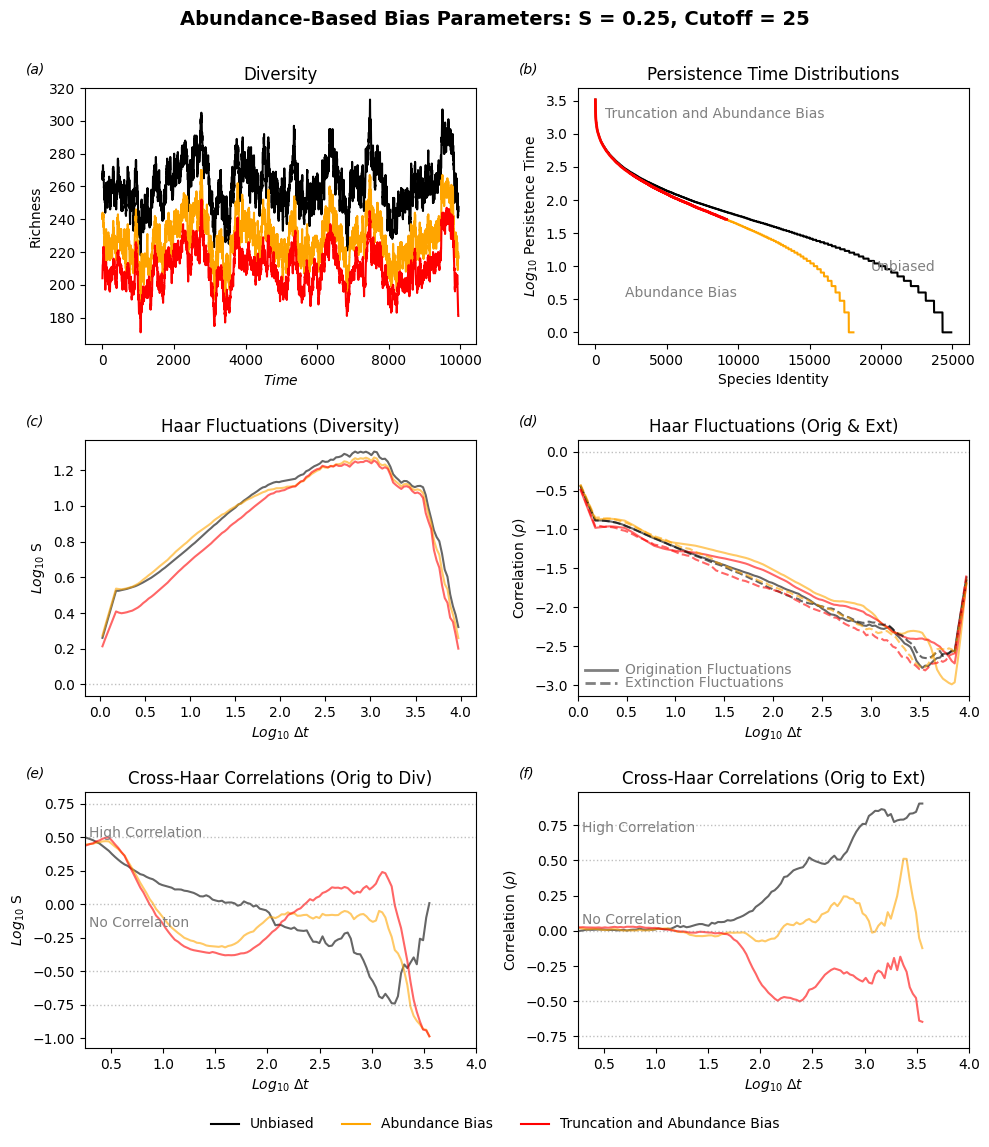

In [ ]:
# Main Figure 3
cmap = plt.get_cmap('magma', 3)
colors = [cmap(i) for i in range(3)]  # 3 variants: Unbiased, Abundance Bias, Truncation+Abundance
colors = ["black", "orange", "red"]
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
K = 10 # Convolution kernal window size

### a
# Diversity Curves
axs[0, 0].plot(np.arange(len(unbiased_r2f3[0][25:-25])), unbiased_r2f3[0][25:-25], c=colors[0], label="Unbiased")
axs[0, 0].plot(np.arange(len(sp_r2f3[0][25:-25])), sp_r2f3[0][25:-25], c=colors[1], label="Abundance Bias")
axs[0, 0].plot(np.arange(len(ab_r2f3[0][25:-25])), ab_r2f3[0][25:-25], c=colors[2], label="Truncation and Abundance")
axs[0, 0].set_title("Diversity")
### b
# Persistence Curves
axs[0, 1].plot(np.log10(unbiased_curve[0]), c=colors[0])
axs[0, 1].plot(np.log10(sp_curve[0]), c=colors[1])
axs[0, 1].plot(np.log10(ab_curve[0]), c=colors[2], linewidth = 2)
axs[0, 1].set_title("Persistence Time Distributions")

# Convolution Kernel Window
### c
# Haar Diversity
axs[1, 0].plot(np.log10(unbiased_hr_2f3[0][:, 0]), np.convolve(np.log10(unbiased_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[1, 0].plot(np.log10(sp_hr_2f3[0][:, 0]), np.convolve(np.log10(sp_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[1, 0].plot(np.log10(ab_hr_2f3[0][:, 0]), np.convolve(np.log10(ab_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[1, 0].set_title("Haar Fluctuations (Diversity)")

### d
# Origination Haar
axs[1, 1].plot(np.log10(unbiased_or_2f3[0][:, 0]), np.convolve(np.log10(unbiased_or_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[1, 1].plot(np.log10(sp_or_2f3[0][:, 0]), np.convolve(np.log10(sp_or_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[1, 1].plot(np.log10(ab_or_2f3[0][:, 0]), np.convolve(np.log10(ab_or_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[1, 1].set_title("Haar Fluctuations (Orig & Ext)")
# Extinction Haar
axs[1, 1].plot(np.log10(unbiased_er_2f3[0][:, 0]), np.convolve(np.log10(unbiased_er_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6, linestyle = "dashed")
axs[1, 1].plot(np.log10(sp_er_2f3[0][:, 0]), np.convolve(np.log10(sp_er_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6, linestyle = "dashed")
axs[1, 1].plot(np.log10(ab_er_2f3[0][:, 0]), np.convolve(np.log10(ab_er_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6, linestyle = "dashed")

### e
# Cross-Haar Correlations
axs[2, 0].plot(np.log10(unbiased_or_2f3[0][:, 0]),  np.convolve(unbiased_corr_od_2f3[0], np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[2, 0].plot(np.log10(sp_or_2f3[0][:, 0]),  np.convolve(sp_corr_od_2f3[0], np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[2, 0].plot(np.log10(ab_or_2f3[0][:, 0]),  np.convolve(ab_corr_od_2f3[0], np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[2, 0].set_title("Cross-Haar Correlations (Orig to Div)")

# Add horizontal reference lines
for y in [0.75, -0.75, 0.5, -0.5, 0]:
    axs[2, 0].axhline(y, color="gray", linestyle=':', linewidth=1, alpha=0.5)

### f
# Cross-Haar Correlations
axs[2, 1].plot(np.log10(unbiased_or_2f3[0][:, 0]), np.convolve(unbiased_corr_oe_2f3[0], np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[2, 1].plot(np.log10(sp_or_2f3[0][:, 0]), np.convolve(sp_corr_oe_2f3[0], np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[2, 1].plot(np.log10(ab_or_2f3[0][:, 0]), np.convolve(ab_corr_oe_2f3[0], np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[2, 1].set_title("Cross-Haar Correlations (Orig to Ext)")

# Add horizontal reference lines
for y in [0.75, -0.75, 0.5, -0.5, 0]:
    axs[2, 1].axhline(y, color="gray", linestyle=':', linewidth=1, alpha=0.5)

# Set layout
fig.tight_layout()

# Shared legend outside the plot
fig.legend(["Unbiased", "Abundance Bias", "Truncation and Abundance Bias"], 
           loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.01))

# labels
axs[0,0].set_xlabel(r'$Time$')
axs[0,0].set_ylabel(r'Richness')
axs[0,1].set_xlabel(r'Species Identity')
axs[0,1].set_ylabel(r'$Log_{10}$ Persistence Time')

axs[1,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,0].set_ylabel(r'$Log_{10}$ S')
axs[1,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,1].set_ylabel(r'Correlation $(\rho)$')

axs[2,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[2,0].set_ylabel(r'$Log_{10}$ S')
axs[2,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[2,1].set_ylabel(r'Correlation $(\rho)$')

subplot_letters = [
"(a)", "(b)","(c)", "(d)",
"(e)", "(f)"
]

# Plot Letters
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = i * 2 + j
        ax.text(-0.15, 1.1, subplot_letters[idx], transform=ax.transAxes,
            fontsize=10, fontstyle='italic', va='top', ha='left')

# Figures Text Captions 
font_s = 10
# (b)
axs[0, 1].text(0.07, 0.9, "Truncation and Abundance Bias",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[0, 1].text(0.12, 0.2, "Abundance Bias",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[0, 1].text(0.75, 0.3, "Unbiased",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 0].axhline(0, color="gray", linestyle=':', linewidth=1, alpha=0.5)

# (c)
axs[1, 1].plot([0.02, 0.10], [0.1, 0.1],transform=axs[1, 1].transAxes,color='grey',linewidth=2,linestyle='-',clip_on=False)
axs[1, 1].text(0.12, 0.1, "Origination Fluctuations",transform=axs[1, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 1].plot([0.02, 0.10], [0.05, 0.05],transform=axs[1, 1].transAxes,color='grey',linewidth=2,linestyle='--',clip_on=False)
axs[1, 1].text(0.12, 0.05, "Extinction Fluctuations",transform=axs[1, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 1].axhline(0, color="gray", linestyle=':', linewidth=1, alpha=0.5)
axs[1, 1].set_xlim(0, 4)

# (d)
axs[2, 0].text(0.01, 0.84, "High Correlation", transform=axs[2, 0].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 0].text(0.01, 0.49, "No Correlation", transform=axs[2, 0].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 0].set_xlim(0.25, 4)

# (e)
axs[2, 1].text(0.01, 0.86, "High Correlation", transform=axs[2, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 1].text(0.01, 0.50, "No Correlation", transform=axs[2, 1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[2, 1].set_xlim(0.25, 4)

plt.subplots_adjust(bottom=0.06)  # Extra space for legend

fig.suptitle("Abundance-Based Bias Parameters: S = 0.25, Cutoff = 25", fontsize=14, y=0.935, fontweight="bold")
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(top=0.87, bottom=0.07)
plt.savefig(tiff_save_path_1, format='png', dpi=300, bbox_inches='tight',transparent=False)